# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.


# Laboratory 4 - Neural Netoworks Training - Supervised


The goal of the Laboratory 4 is to:

<ul>
  <li> Familarize yourself with the gradient descent algorithm.
  <li> Get familiar with the neural network training process.
  <li> Train a neural network for the classification of brain tumors in the MRI images.
  <li> Understand the training hyperparameters: batch size, number of epochs, learning rate.
</ul>

You are going to: (i) implement the gradient descent algorithm in PyTorch, (ii) implement a simple convolutional network
architecture, (iii) train the neural network using the supervised strategy (for image classification).


### Part I - Gradient Descent


The first part of the laboratory is not directly connected with the neural network training process but it is useful to
understand the general concept.

You will start by implementing a simple version of the gradient descent algorithm. You can build the intuition by
reading:

http://mlwiki.org/index.php/Gradient_Descent

The gradient algorithm is the predecessor of the state-of-the-art optimization methods used to train the deep neural
network like SGD or Adam - the methods you will use in the next parts of the laboratory. It is a first order
gradient-based optimization method.

Let's start by generating a simple function. Your task will be to find the minimum of the function by the gradient
descent (using PyTorch).


In [9]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt

# Let f(x, y) = x**2 + y**2
# Let's minimize the function analytically
# Gf(x) = [df(x, y) / dx, df(x, y) / dy] = [2*x, 2*y]
# 2*x = 0
# 2*y = 0
# The minimum is clearly defined (x, y) = (0, 0)
# Now verify this by the gradient descent

In [10]:
# Implement the gradient descent here
def gradient_descent(f, initial_guess, num_iters, learning_rate, echo=False):
    """
    f - function (callable) : function taking N variables as input
    num_iters - int : number of iterations
    initial_guess - Tensor : vector of N variables
    learning_rate - float: the learning rate for the gradient descent update
    echo - bool: whether to print the results during each iteration
    Note: Implement the gradient calculation on your own
    """
    result = initial_guess  # TODO - intialize the result
    step = 0.001  # Some inner step inside the function to calculate the gradient
    for i in range(num_iters):
        gradient = calculate_gradient(f, result, step)  # TODO - calculate the numerical gradient for each iteration
        result -= learning_rate * tc.tensor(gradient)  # TODO - update the arguments using the gradient descent equation
        if echo:  # TODO - print the current result and the function value for this result
            print(f"Iteration {i + 1}: Result = {result}, Function Value = {f(*result)}")
    return result


def calculate_gradient(f, x, step):
    gradient = []
    for i in range(len(x)):
        x_plus_delta = x.clone()
        x_minus_delta = x.clone()

        x_plus_delta[i] += step
        x_minus_delta[i] -= step

        gradient.append((f(*x_plus_delta) - f(*x_minus_delta)) / (2 * step))

    return gradient

Now let's verify the implementation:


In [11]:
f = lambda x, y: x**2 + y**2
initial_guess = tc.randn(2).type(tc.float32)  # Let's start with some two random numbers
num_iters = 50
learning_rate = 0.1
echo = True

result = gradient_descent(f, initial_guess, num_iters, learning_rate, echo)
print(f"Initial arguments: {initial_guess}, Value of the function for the initial arguments: {f(*initial_guess)}")
print(f"Result: {result}, Value of the function at the result: {f(*result)}")

Iteration 1: Result = tensor([1.3345, 0.0025]), Function Value = 1.780919075012207
Iteration 2: Result = tensor([1.0676, 0.0020]), Function Value = 1.1397587060928345
Iteration 3: Result = tensor([0.8541, 0.0016]), Function Value = 0.7294300198554993
Iteration 4: Result = tensor([0.6833, 0.0013]), Function Value = 0.4668407440185547
Iteration 5: Result = tensor([0.5466, 0.0010]), Function Value = 0.29877984523773193
Iteration 6: Result = tensor([0.4373, 0.0008]), Function Value = 0.1912195086479187
Iteration 7: Result = tensor([0.3498, 0.0006]), Function Value = 0.12238100916147232
Iteration 8: Result = tensor([0.2799, 0.0005]), Function Value = 0.07832430303096771
Iteration 9: Result = tensor([0.2239, 0.0004]), Function Value = 0.05012788623571396
Iteration 10: Result = tensor([0.1791, 0.0003]), Function Value = 0.032081812620162964
Iteration 11: Result = tensor([0.1433, 0.0003]), Function Value = 0.02053235098719597
Iteration 12: Result = tensor([0.1146, 0.0002]), Function Value = 0.

You can observe that the function became a bit unstable during the last iterations. This is connected with the learning
rate: (i) if the learning rate is too high the function can become unstable, (ii) if the learning rate is too low the
time required for optimization will be longer.

Verify the effect of the learning rate:


In [12]:
initial_guess = tc.randn(2).type(tc.float32)  # Let's start with some two random numbers
num_iters = 50
learning_rate_low = 0.01
learning_rate_medium = 0.1
learning_rate_high = 10
echo = False

print()
result_lr_low = gradient_descent(f, initial_guess, num_iters, learning_rate_low, echo)
print()
print(f"Result: {result}, Value of the function at the result: {f(*result_lr_low)}")

print()
result_lr_medium = gradient_descent(f, initial_guess, num_iters, learning_rate_medium, echo)
print()
print(f"Result: {result}, Value of the function at the result: {f(*result_lr_medium)}")

print()
result_lr_high = gradient_descent(f, initial_guess, num_iters, learning_rate_high, echo)
print()
print(f"Result: {result}, Value of the function at the result: {f(*result_lr_high)}")



Result: tensor([2.3808e-05, 4.4145e-08]), Value of the function at the result: 0.6973820924758911


Result: tensor([2.3808e-05, 4.4145e-08]), Value of the function at the result: 1.4206329168597875e-10


Result: tensor([2.3808e-05, 4.4145e-08]), Value of the function at the result: 35956842496.0


You can observe that for the low learning rate the function requires more iterations to converge, the medium learning
rate is more or less acceptable, while the high learning rate led to an unstability during the training process.

Next, let's implement the gradient descent again, however, this time use the PyTorch Autograd to calculate the gradient.

You may find useful to first read:

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html


In [13]:
from torch.autograd import Variable


# Implement the gradient descent here
def gradient_descent_autograd(f, initial_guess, num_iters, learning_rate, echo=False):
    """
    f - function (callable) :of N variables
    num_iters - int : number of iterations
    initial_guess - Tensor : vector of N variables
    learning_rate - float: the learning rate for gradient descent update
    echo - bool: whether to print the results during each iteration
    Note: Implement the gradient calculation using PyTorch Autograd
    """
    result = Variable(initial_guess, requires_grad=True)
    for i in range(num_iters):
        result.retain_grad()  # Ensure we can compute the gradient

        output = f(*result)  # Calculate the function value
        output.backward()  # Compute gradients

        gradient = result.grad  # Get the gradient

        result.data -= learning_rate * gradient

        if echo:
            print(f"Iteration {i + 1}: Result = {result.data}, Function Value = {output.item()}")

    return result.data

Verify the correctness. Moreover, compare the running time with the previously implemented function (with echo = False).


In [14]:
import time
initial_guess = tc.randn(2).type(tc.float32)
num_iters = 50
learning_rate = 0.1
echo = False

# Measure execution time for gradient_descent
start_time = time.time()
result = gradient_descent(f, initial_guess, num_iters, learning_rate, echo)
end_time = time.time()
print(f"Execution time for gradient_descent: {end_time - start_time:.6f} seconds")

# Measure execution time for gradient_descent_autograd
start_time = time.time()
result_autograd = gradient_descent_autograd(f, initial_guess, num_iters, learning_rate, echo)
end_time = time.time()
print(f"Execution time for gradient_descent_autograd: {end_time - start_time:.6f} seconds")

# Print results
print(f"Initial arguments: {initial_guess}, Value of the function for the initial arguments: {f(*initial_guess)}")
print(f"Result: {result}, Value of the function at the result: {f(*result)}")
print(f"Result Autograd: {result_autograd}, Value of the function at the result: {f(*result_autograd)}")


Execution time for gradient_descent: 0.016001 seconds
Execution time for gradient_descent_autograd: 0.011003 seconds
Initial arguments: tensor([-6.8388e-06,  4.0380e-06]), Value of the function for the initial arguments: 6.307446231978986e-11
Result: tensor([-6.8388e-06,  4.0380e-06]), Value of the function at the result: 6.307446231978986e-11
Result Autograd: tensor([-6.8388e-06,  4.0380e-06]), Value of the function at the result: 6.307446231978986e-11


You can see that both the method work. However, the Autograd outputs more accurate results. The reason for this is
connected with the fact that Autograd attempts to configure the gradient as accurately as possible (e.g. by choosing a
dedicated gradient step). A speed-up compared with the naive gradient approximiation could be observed with more
real-like problems (more variables) and using GPUs.


### Part II - Convolutional Neural Network


Let's now implement a simple neural network. Following the knowledge and skills you gained during Laboratory 2.

Implement a neural network with the following architecture:

<ul>
  <li> Conv2D with:
    <ul>
      <li> Input channels: 1
      <li> Output channels: 32
      <li> Kernel size: 3
      <li> Stride : 1
      <li> Padding: 1
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 32
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 1
      <li> Padding: 1
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 1
    </ul>
  <li> BatchNorm2D
  <li> ReLU activation function
  <li> Adaptive Average Pooling to size (B, 128, 1, 1)
  <li> Linear layer with input size: 64, and output size: 64
  <li> ReLU activation function
  <li> Linear layer with input size: 64 and output size: 64
  <li> ReLU activation function
  <li> Linear layer with input size: 64 and output size: 4
</ul>


In [15]:
import torch
import torch.nn as nn

class ClassificationNetwork(nn.Module):
    def __init__(self):
        super(ClassificationNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=2)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=2)
        self.batchnorm5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()

        self.adaptive_avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_features=64, out_features=64)
        self.relu6 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.relu7 = nn.ReLU()

        self.fc3 = nn.Linear(in_features=64, out_features=4)

    def forward(self, x):
        x = self.relu1(self.batchnorm1(self.conv1(x)))
        x = self.relu2(self.batchnorm2(self.conv2(x)))
        x = self.relu3(self.batchnorm3(self.conv3(x)))
        x = self.relu4(self.batchnorm4(self.conv4(x)))
        x = self.relu5(self.batchnorm5(self.conv5(x)))
        x = self.adaptive_avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu6(self.fc1(x))
        x = self.relu7(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the SimpleNeuralNetwork
net = ClassificationNetwork()


And generate random input to the verify whether the neural networks processes the input correctly:


In [18]:
from torchsummary import summary

device = "cuda:0" if torch.cuda.is_available() else "cpu"

classification_network = ClassificationNetwork()

batch_size = 4
random_input = tc.randn((batch_size, 1, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
summary(classification_network.to(device), (1, 224, 224))

Size of the random input: torch.Size([4, 1, 224, 224])
Size of the random output: torch.Size([4, 4])
Random output: 
tensor([[ 0.0180,  0.0518,  0.0450, -0.0085],
        [ 0.0217,  0.0532,  0.0447, -0.0076],
        [ 0.0251,  0.0541,  0.0478, -0.0066],
        [ 0.0191,  0.0506,  0.0471, -0.0083]], grad_fn=<AddmmBackward0>)
Network summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 113, 113]          18,496
       BatchNorm2d-5         [-1, 64, 113, 113]             128
              ReLU-6         [-1, 64, 113, 113]               0
            Conv2d-7         [-1, 64, 113, 113]          36,928
       BatchNorm2d-8         [-1, 64, 113, 113]             128
             

### Part III - Dataset, Dataloader


You are going to use the dataset from the Laboratory 3 dedicated to tumor classification in the MRI images. Mount the
google drives, create the pathes and copy-paste the dataloader (the extended version) to the cell below:


In [19]:
import os
import pandas as pd
dataset_path = "lab3_data"
training_csv_path = os.path.join(dataset_path, "training.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

# Repeat the process from the init function to create pandas dataframe
# containing three components: (image_path, image_class_number, image_class_name)
classes = os.listdir(f"{dataset_path}/Training")

print(f"Available classes: {classes}")
classes_dict = {classes[i]: i for i in range(len(classes))}
print(f"Classes dict: {classes_dict}")

training_cases = []
testing_cases = []
for current_class in classes:
    training_dir = os.path.join(dataset_path, "Training", current_class)
    testing_dir = os.path.join(dataset_path, "Testing", current_class)

    for current_case in os.listdir(training_dir):
        training_cases.append((os.path.join(training_dir, current_case), classes_dict[current_class], current_class))

    for current_case in os.listdir(testing_dir):
        testing_cases.append((os.path.join(testing_dir, current_case), classes_dict[current_class], current_class))

training_df = pd.DataFrame(training_cases, columns=['path', 'class_number', 'class_name'])
testing_df = pd.DataFrame(testing_cases, columns=['path', 'class_number', 'class_name'])

training_df.to_csv(training_csv_path, index=False)
testing_df.to_csv(testing_csv_path, index=False)

Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [20]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class BrainMRIDataset(Dataset):
    def __init__(self, dataset_path: str, mode: str="training"):
        self.dataset_path = dataset_path
        self.mode = mode  # "training" or "testing"

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "Training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "Testing")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path)  # Assumption that the classes are represented by the folder names
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}")  # Mapping from the classes to numbers

        # Creation of all training cases in the form of a list containing tuples with: (path_to_file, class_number)
        self.cases = []
        for class_idx, current_class in enumerate(self.classes):
            class_path = os.path.join(self.data_path, current_class)
            for current_case in os.listdir(class_path):
                case_path = os.path.join(class_path, current_case)
                self.cases.append((case_path, class_idx))

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])

    def __len__(self):
        # Overload the function responsible to determine the size of the dataset
        return len(self.cases)

    def __getitem__(self, idx):
        # Overload the function responsible to load a single image from the dataset
        current_case_path, current_class = self.cases[idx]

        # Load and transform the image
        current_image = Image.open(current_case_path).convert('L')  # convert to grayscale
        current_image = self.transform(current_image)

        return current_image, current_class


Verify whether the data is being loaded correctly:


Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


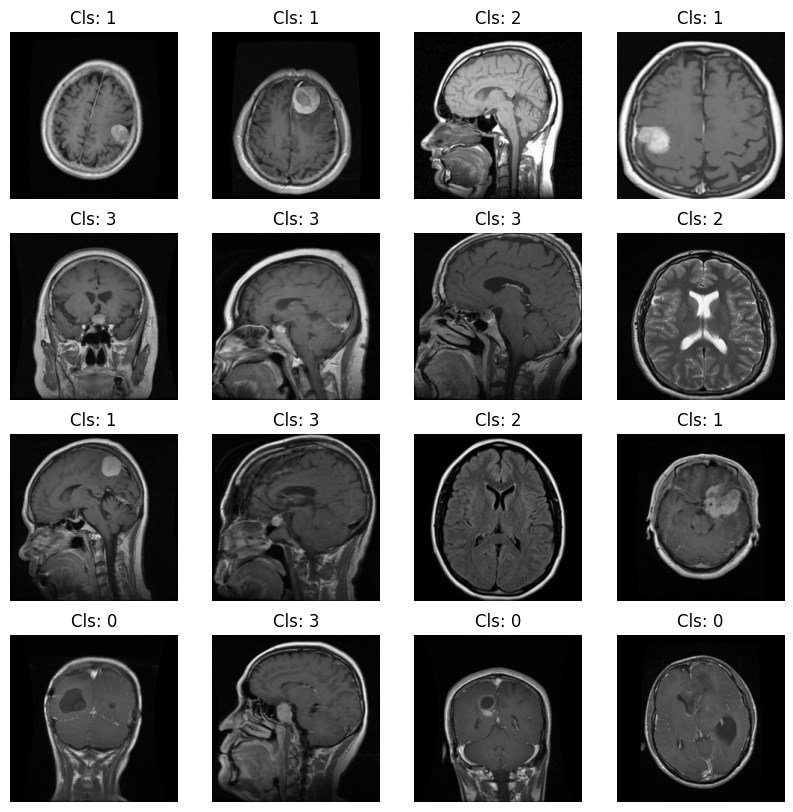

In [21]:
from torch.utils.data import DataLoader

mri_dataset = BrainMRIDataset("lab3_data") #TODO - create the dataset object
batch_size = 16
shuffle = True
mri_dataloader = DataLoader(mri_dataset, batch_size=batch_size, shuffle=shuffle) #TODO - create the dataloader object
figure = plt.figure(figsize=(10,10))

for images, classes in mri_dataloader:
  cols, rows = 4, 4
  for i in range(rows * cols):
    img, label = images[i], classes[i]
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.title(f"Cls: {label.item()}")
    plt.imshow(img.squeeze(), cmap="gray")
  break
plt.show()

### Part IV - Network Training


Now it's the time to train the neural network. During this laboratory you are going to do this in a supervised manner.
It means that the ground-truth labels will be provided during the training process to guide the network parameters into
local minima of the objective function dedicated to image classification.

This time you will analyze the training process in a simplified way by accumulating and visualizing the process using
matplotlib. More advanced TensorBoard logging will be the task during the next Laboratory.

Start with creating the training function.


In [22]:
import torch.nn as nn
import torch.optim as optim

def training(model, training_dataloader, testing_dataloader, training_params):
    num_epochs = training_params["num_epochs"]
    learning_rate = training_params["learning_rate"]

    objective_function = nn.CrossEntropyLoss()
    parameters = model.parameters()
    optimizer = optim.Adam(parameters, lr=learning_rate)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Device: {device}")

    training_losses = []
    testing_losses = []
    model = model.to(device)

    print(f"Training dataset size: {len(training_dataloader.dataset)}")
    print(f"Testing dataset size: {len(testing_dataloader.dataset)}")
    for epoch in range(num_epochs):
        print(f"Current epoch: {epoch + 1}/{num_epochs}")

        training_epoch_loss = 0.0
        model.train()
        for batch_idx, (images, classes) in enumerate(training_dataloader):
            images, classes = images.to(device), classes.to(device)
            optimizer.zero_grad()

            output = model(images)
            loss = objective_function(output, classes)
            loss.backward()
            optimizer.step()

            training_epoch_loss += loss.item()

            # Print the percentage of completion
            percentage_completion = (batch_idx + 1) / len(training_dataloader) * 100
            print(f"\rBatch: {batch_idx + 1}/{len(training_dataloader)}, {percentage_completion:.2f}% complete", end="")

        training_epoch_loss = training_epoch_loss / len(training_dataloader.dataset)
        training_losses.append(training_epoch_loss)
        print(f"\nCurrent epoch training loss: {training_epoch_loss}")

        testing_epoch_loss = 0.0
        model.eval()
        for images, classes in testing_dataloader:
            images, classes = images.to(device), classes.to(device)
            with torch.no_grad():
                output = model(images)
                loss = objective_function(output, classes)

            testing_epoch_loss += loss.item()

        testing_epoch_loss = testing_epoch_loss / len(testing_dataloader.dataset)
        testing_losses.append(testing_epoch_loss)
        print(f"Current epoch testing loss: {testing_epoch_loss}")

    return model, training_losses, testing_losses


Now define the training hyperparameters and create the training/testing dataloader (note: during this laboratory you not
have the validation dataloader and the testing set is used as the validation dataloader, it will be modified during the
next Laboratory):


In [56]:
learning_rate = 0.003
batch_size = 32
num_epochs = 1
shuffle = True
model = ClassificationNetwork()

training_params = {
    "learning_rate": learning_rate,
    "num_epochs": num_epochs,
}

training_dataset = BrainMRIDataset(dataset_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

testing_dataset = BrainMRIDataset(dataset_path)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


Run the training:


In [57]:
torch.cuda.is_available()

False

In [58]:
model, training_losses, testing_losses = training(model, training_dataloader, testing_dataloader, training_params)

Training dataset size: 2870
Testing dataset size: 2870
Current epoch: 1/100
Batch: 22/90, 24.44% complete

KeyboardInterrupt: 

And finally visualize the training/validation process by showing the loss during each epoch (as below):


In [55]:
plt.plot(training_losses, label='Training Loss')
plt.plot(testing_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid lines
plt.title('Training and Testing Losses Over Epochs')
plt.show()

NameError: name 'training_losses' is not defined

Do you see any problems? What went wrong? What whould happen after inreasing the number of training epochs?

You have just finished the training of the neural network. The next task is to analyze the obtained results.


### Part V - Result Analysis


In the last part of the Laboratory you are going to analyze the results. First, you are going to show the confusion
matrices for the training and testing sets. Then, you will visualize the cases for which the network failed.

Start with creating function responsible for accumulating the results. The function should perform a single pass through
a dataloader and accumulate all predicitions, together with the corresponding group truth labels.


In [49]:
def accumulate_predictions(model, dataloader):
    predictions = []
    targets = []
    device = "cuda:0" if tc.cuda.is_available() else "cpu"
    model.eval()
    
    with tc.no_grad():
        print(f"Dataset size: {len(dataloader.dataset)}")
        for images, classes in dataloader:
            images, classes = images.to(device), classes.to(device)
            output = model(images)
            
            _, batch_predictions = output.max(dim=1)
            
            predictions.extend(batch_predictions.cpu().numpy())
            targets.extend(classes.cpu().numpy())

    return predictions, targets

# Example usage:
# Ensure your model and dataloaders are defined and trained
# model, training_losses, testing_losses = training(model, training_dataloader, testing_dataloader, training_params)

# Assuming "device" is defined as well
device = "cuda:0" if tc.cuda.is_available() else "cpu"

# Accumulate results for training set
training_predictions, training_targets = accumulate_predictions(model, training_dataloader)

# Accumulate results for testing set
testing_predictions, testing_targets = accumulate_predictions(model, testing_dataloader)


AttributeError: 'list' object has no attribute 'dataset'

Now use the function to accumulate the results for training/testing dataloaders and use **sklearn** to show the
confusion matrices and classification summary.


In [48]:
import sklearn.metrics as metrics

target_names = ["Glioma", "Meningioma", "Healthy", "Pituitary"]
# Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
# Compute confusion matrix for training set
training_confusion_matrix = metrics.confusion_matrix(training_targets, training_predictions)

# Print classification report for training set
print("Training Classification Report:")
print(metrics.classification_report(training_targets, training_predictions, target_names=target_names))

# Accumulate results for testing set
# Compute confusion matrix for testing set
testing_confusion_matrix = metrics.confusion_matrix(testing_targets, testing_predictions)

# Print classification report for testing set
print("\nTesting Classification Report:")
print(metrics.classification_report(testing_targets, testing_predictions, target_names=target_names))

# You can also print or visualize the confusion matrices if desired
print("\nTraining Confusion Matrix:")
print(training_confusion_matrix)

print("\nTesting Confusion Matrix:")
print(testing_confusion_matrix)


Training Classification Report:
              precision    recall  f1-score   support

      Glioma       0.57      0.99      0.73       826
  Meningioma       0.84      0.28      0.42       822
     Healthy       0.78      0.97      0.86       395
   Pituitary       0.99      0.79      0.88       827

    accuracy                           0.73      2870
   macro avg       0.79      0.76      0.72      2870
weighted avg       0.80      0.73      0.70      2870


Testing Classification Report:
              precision    recall  f1-score   support

      Glioma       0.57      0.99      0.73       826
  Meningioma       0.84      0.28      0.42       822
     Healthy       0.78      0.97      0.86       395
   Pituitary       0.99      0.79      0.88       827

    accuracy                           0.73      2870
   macro avg       0.79      0.76      0.72      2870
weighted avg       0.80      0.73      0.70      2870


Training Confusion Matrix:
[[821   3   2   0]
 [496 230  89   7]


What went wrong? Why the results for the training set are so different from the testing set?

Finally, prepare the visualization similar to the one below but showing example of incorrectly classified cases. Show
next to the given image the real class and the predicted one.


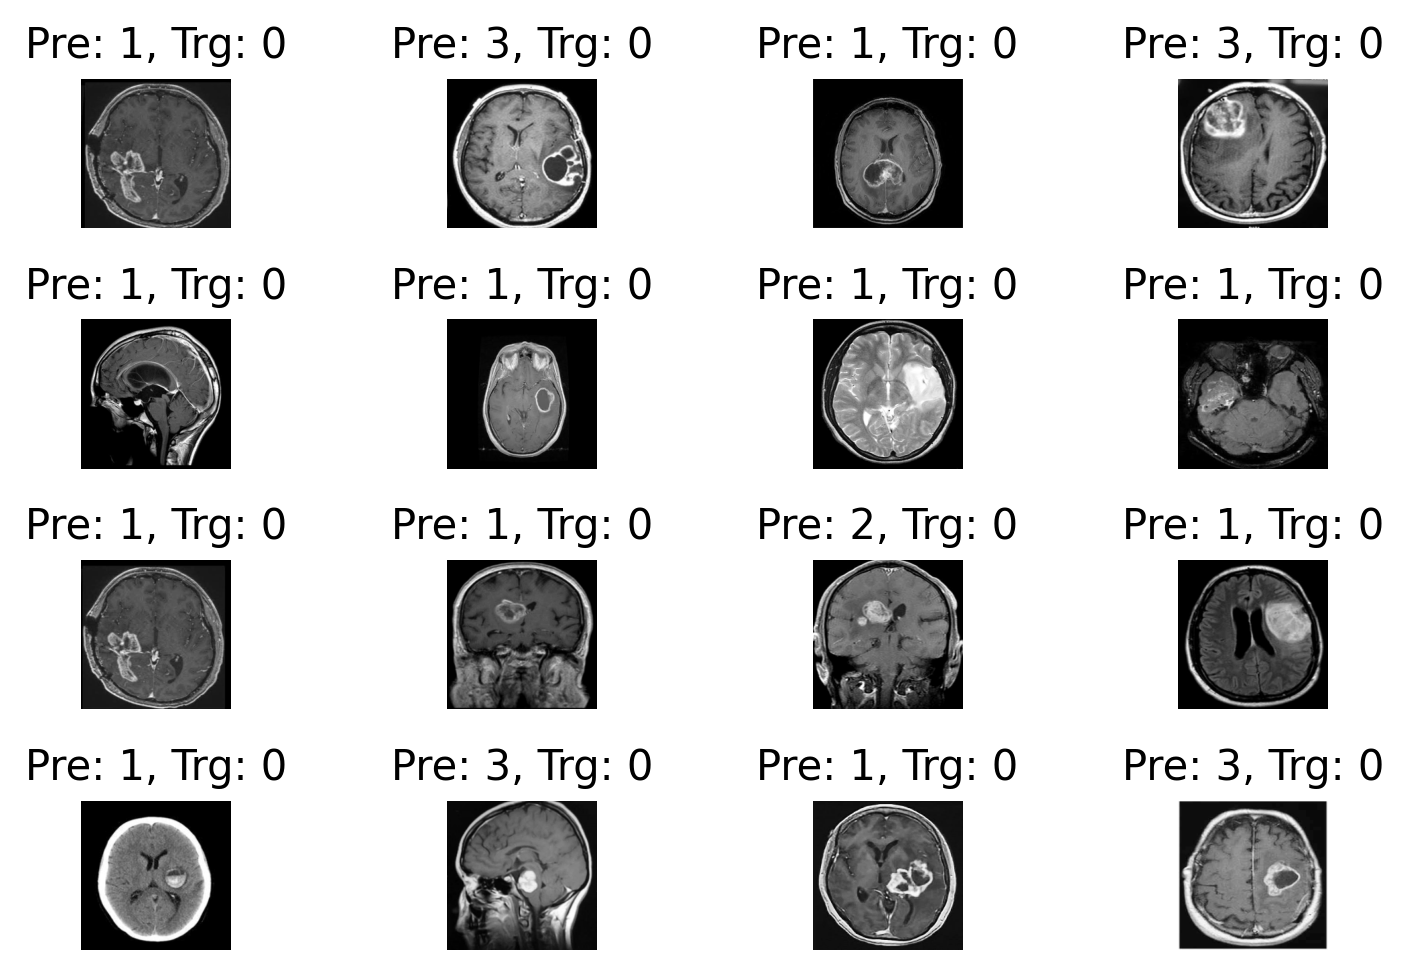

In [ ]:
# TODO: Prepare the visualization as below

# TODO

What can you say about the results using the confusion matrices and the visualization? Is the classification working
correctly? What's wrong? Do you have any idea how to improve the results? Hint: visually examine the images for each
class, both in the training and the testing set.

We will continue the classification topic during the next laboratory using different dataset and a pretrained ResNet18
architecture.


### Conclusion


Congratulations, you have implemented the gradient descent method, the supervised training pipeline and prepared the
training setup for the medical image classification.

After the laboratory you should:

<ul>
  <li> Understand the intuition behind the gradient descent method.
  <li> Be able to implement your own training pipeline for the supervised learning.
  <li> Modify the training hyperparameters to verify their influence on the final results.
</ul>

During the next laboratory you are going to extend the knowledge for classification of XRay images by image
augmentation, transfer learning from pretrained ResNet18 network, and logging using TensorBoard. You will also extend
the evaluation beyond the confusion matrix and simple visualization.
